In [ ]:
import tensorflow as tf
import pathlib
import pandas as pd
import os
import io
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/spam.csv", encoding="ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")

In [ ]:
df["v2_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["v2_clean"] = df["v2_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["v2_clean"] = df["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df.head()


,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [ ]:
mask = df["v2_clean"].apply(lambda x: type(x)==str)
mask.value_counts()
df = df.loc[mask,:]

In [ ]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words =1000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df["v2_clean"])
df["v2_encoded"] = tokenizer.texts_to_sequences(df["v2_clean"])
df.head()

,v1,v2,v2_clean,v2_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 230, 447, 464, 942, 32, 50, 204, 943, 78, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 195, 465, 289, 2, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 533, 662, 30, 1, 849, 424, 1, 1, ..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 150, 1, 2, 79]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[705, 20, 663, 129]"


In [ ]:
df["v1"] = df["v1"].apply(lambda x: 0 if x =='ham' else 1)
df.head()

,v1,v2,v2_clean,v2_encoded
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 230, 447, 464, 942, 32, 50, 204, 943, 78, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 195, 465, 289, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 533, 662, 30, 1, 849, 424, 1, 1, ..."
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 150, 1, 2, 79]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[705, 20, 663, 129]"


In [ ]:
v2_pad = tf.keras.preprocessing.sequence.pad_sequences(df["v2_encoded"], padding="post")

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(v2_pad, df["v1"], test_size=0.2)

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [ ]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[v2.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 8)             8008      
                                                                 
 global_average_pooling1d_10  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_22 (Dense)            (None, 16)                144       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Model training
history = model.fit(train_batch,
          epochs=50,
          validation_data=val_batch)

Epoch 1/100
70/70 [==============================] - 1s 5ms/step - loss: 0.6021 - binary_accuracy: 0.8436 - val_loss: 0.5014 - val_binary_accuracy: 0.8700
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.4318 - binary_accuracy: 0.8649 - val_loss: 0.3735 - val_binary_accuracy: 0.8700
Epoch 3/100
70/70 [==============================] - 0s 4ms/step - loss: 0.3672 - binary_accuracy: 0.8649 - val_loss: 0.3481 - val_binary_accuracy: 0.8700
Epoch 4/100
70/70 [==============================] - 0s 4ms/step - loss: 0.3513 - binary_accuracy: 0.8649 - val_loss: 0.3335 - val_binary_accuracy: 0.8700
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 0.3347 - binary_accuracy: 0.8649 - val_loss: 0.3157 - val_binary_accuracy: 0.8700
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 0.3132 - binary_accuracy: 0.8649 - val_loss: 0.2912 - val_binary_accuracy: 0.8700
Epoch 7/100
70/70 [==============================] - 0s 4ms/step - los

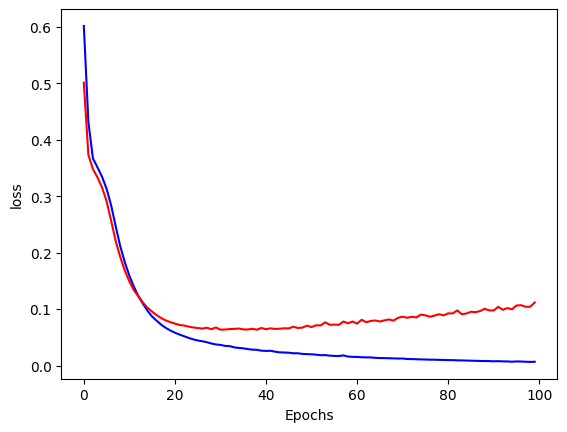

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

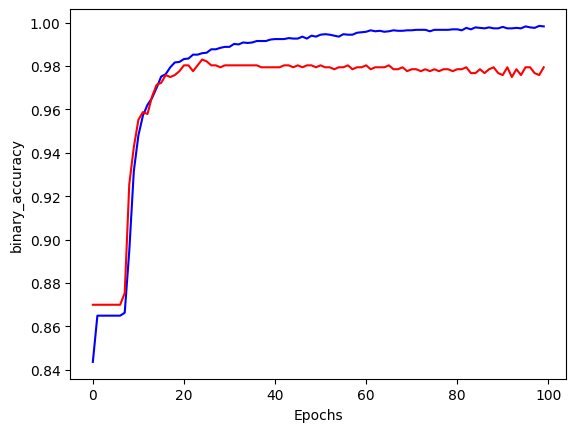

In [ ]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

model_simple = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[v2.shape[1],],name="embedding"),
                  SimpleRNN(units=64, return_sequences=False),
                  Dense(1, activation="sigmoid")
])

In [ ]:
model_simple.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            64064     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 72,385
Trainable params: 72,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer= tf.keras.optimizers.Adam()

model_simple.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Model training
history = model_simple.fit(train_batch,
          epochs=30,
          validation_data=val_batch)

Epoch 1/50
70/70 [==============================] - 4s 37ms/step - loss: 0.4158 - binary_accuracy: 0.8557 - val_loss: 0.3870 - val_binary_accuracy: 0.8700
Epoch 2/50
70/70 [==============================] - 2s 31ms/step - loss: 0.3969 - binary_accuracy: 0.8649 - val_loss: 0.3873 - val_binary_accuracy: 0.8700
Epoch 3/50
70/70 [==============================] - 3s 50ms/step - loss: 0.3973 - binary_accuracy: 0.8649 - val_loss: 0.3865 - val_binary_accuracy: 0.8700
Epoch 4/50
70/70 [==============================] - 2s 32ms/step - loss: 0.3974 - binary_accuracy: 0.8649 - val_loss: 0.3887 - val_binary_accuracy: 0.8700
Epoch 5/50
70/70 [==============================] - 2s 34ms/step - loss: 0.3987 - binary_accuracy: 0.8649 - val_loss: 0.3865 - val_binary_accuracy: 0.8700
Epoch 6/50
70/70 [==============================] - 4s 63ms/step - loss: 0.3965 - binary_accuracy: 0.8649 - val_loss: 0.3866 - val_binary_accuracy: 0.8700
Epoch 7/50
70/70 [==============================] - 4s 55ms/step - los

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
model_gru_reg = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[v2.shape[1],],name="embedding"),
                  GRU(units=32, return_sequences=False),
                  Dense(1, activation="sigmoid")
])

In [ ]:
optimizer= tf.keras.optimizers.Adam()

model_gru_reg.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
history = model_gru_reg.fit(train_batch,
              epochs=30,
              validation_data=val_batch)

Epoch 1/50
70/70 [==============================] - 7s 60ms/step - loss: 0.4526 - binary_accuracy: 0.8649 - val_loss: 0.3886 - val_binary_accuracy: 0.8700
Epoch 2/50
70/70 [==============================] - 4s 60ms/step - loss: 0.3971 - binary_accuracy: 0.8649 - val_loss: 0.3869 - val_binary_accuracy: 0.8700
Epoch 3/50
70/70 [==============================] - 4s 62ms/step - loss: 0.3965 - binary_accuracy: 0.8649 - val_loss: 0.3866 - val_binary_accuracy: 0.8700
Epoch 4/50
70/70 [==============================] - 4s 52ms/step - loss: 0.3962 - binary_accuracy: 0.8649 - val_loss: 0.3867 - val_binary_accuracy: 0.8700
Epoch 5/50
70/70 [==============================] - 5s 75ms/step - loss: 0.3968 - binary_accuracy: 0.8649 - val_loss: 0.3865 - val_binary_accuracy: 0.8700
Epoch 6/50
70/70 [==============================] - 4s 56ms/step - loss: 0.3976 - binary_accuracy: 0.8649 - val_loss: 0.3866 - val_binary_accuracy: 0.8700
Epoch 7/50
70/70 [==============================] - 4s 51ms/step - los

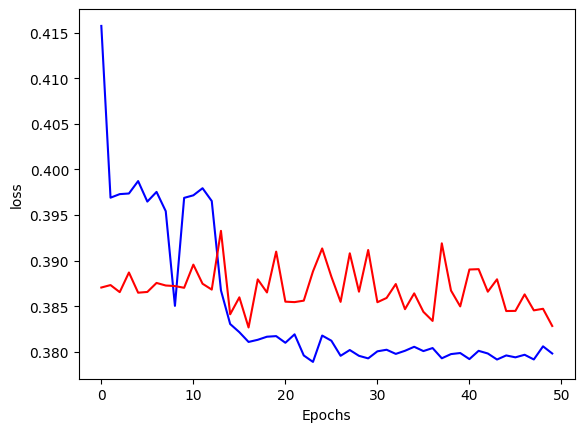

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

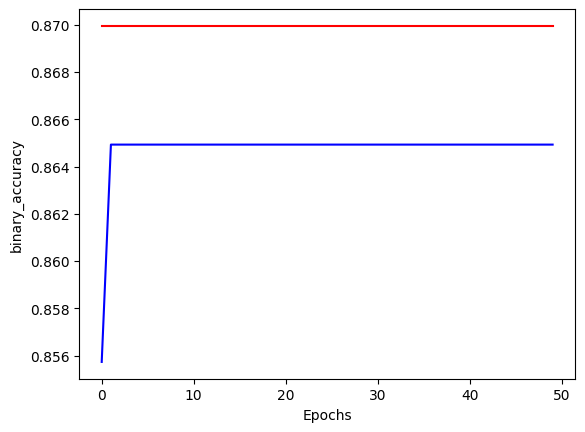

In [ ]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.show()